In [1]:
from tensorflow import keras
keras.__version__

'2.6.0'

In [2]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# 이미지 생성

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/deep-learning-with-python/) 책의 8장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

---

## 변이형 오토인코더

2013년 12월 킹마와 웰링 그리고 2014년 1월 르젠드, 무함마드, 위스트라가 동시에 발견한 변이형 오토인코더는 생성 모델의 한 종류로 개념 벡터를 사용해 이미지를 변형하는데 아주 적절합니다. 오토인코더는 입력을 저차원 잠재 공간으로 인코딩한 다음 디코딩하여 복원하는 네트워크입니다. 변이형 오토인코더는 딥러닝과 베이즈 추론의 아이디어를 혼합한 오토인코더의 최신 버전입니다.

고전적인 오토인코더는 이미지를 입력받아 인코더 모듈을 사용해 잠재 벡터 공간으로 매핑합니다. 그다음 디코더 모듈을 사용해 원본 이미지와 동일한 차원으로 복원하여 출력합니다. 오토인코더는 입력 이미지와 동일한 이미지를 타깃 데이터로 사용하여 훈련합니다. 다시 말해 오토인코더는 원본 입력을 재구성하는 방법을 학습합니다. 코딩(인코더의 출력)에 여러 제약을 가하면 오토인코더가 더 흥미로운 혹은 덜 흥미로운 잠재 공간의 표현을 학습합니다. 일반적으로 코딩이 저차원이고 희소(0이 많은)하도록 제약을 가합니다. 이런 경우 인코더는 입력 데이터의 정보를 적은 수의 비트에 압축하기 위해 노력합니다.

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

현실적으로 이런 전통적인 오토인코더는 특별히 유용하거나 구조화가 잘 된 잠재 공간을 만들지 못합니다. 압축도 아주 뛰어나지 않습니다. 이런 이유 때문에 시대의 흐름에서 대부분 멀어졌습니다. VAE는 오토인코더에 약간의 통계 기법을 추가하여 연속적이고 구조적인 잠재 공간을 학습하도록 만들었습니다. 결국 이미지 생성을 위한 강력한 도구로 탈바꿈되었습니다.

입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신 VAE는 이미지를 어떤 통계 분포의 파라미터로 변환합니다. 이는 입력 이미지가 통계적 과정을 통해서 생성되었다고 가정하여 인코딩과 디코딩하는 동안 무작위성이 필요하다는 것을 의미합입니다. VAE는 평균과 분산 파라미터를 사용해 이 분포에서 무작위로 하나의 샘플을 추출합니다. 이 샘플을 디코딩하여 원본 입력으로 복원합니다(그림 8-13 참조). 이런 무작위한 과정은 안정성을 향상하고 잠재 공간 어디서든 의미있는 표현을 인코딩하도록 만듭니다. 즉 잠재 공간에서 샘플링한 모든 포인트는 유효한 출력으로 디코딩됩니다.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

기술적으로 보면 VAE는 다음과 같이 작동합니다. 먼저 인코더 모듈이 입력 샘플 `imput_img`을 잠재 공간의 두 파라미터 `z_mean`과 `z_log_variance`로 변환합니다. 그다음 입력 이미지가 생성되었다고 가정한 잠재 공간의 정규 분포에서 포인트 `z`를 `z = z_mean + exp(0.5 * z_log_variance) * epsilon`와 같이 무작위로 샘플링합니다. `epsilon`는 작은 값을 가진 랜덤 텐서입니다. 마지막으로 디코더 모듈은 잠재 공간의 이 포인트를 원본 입력 이미지로 매핑하여 복원합니다. `epsilon`이 무작위로 만들어지기 때문에 `input_img`를 인코딩한 잠재 공간의 위치(`z_mean`)에 가까운 포인트는 `input_img`와 비슷한 이미지로 디코딩될 것입니다. 이는 잠재 공간을 연속적이고 의미 있는 공간으로 만들어 줍니다. 잠재 공간에서 가까운 두 개의 포인트는 아주 비슷한 이미지로 디코딩될 것입니다. 잠재 공간의 이런 저차원 연속성은 잠재 공간에서 모든 방향이 의미있는 데이터 변화의 축을 인코딩하도록 만듭니다. 결국 잠재 공간은 매우 구조적이고 개념 벡터로 다루기에 매우 적합해집니다.

VAE의 파라미터는 두 개의 손실 함수로 훈련합니다. 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실과 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실입니다.

케라스의 VAE 구현을 간단히 살펴보겠습니다. 개략적으로 보면 다음과 같습니다:

```python
# 입력을 평균과 분산 파라미터로 인코딩합니다
z_mean, z_log_variance = encoder(input_img)

# 무작위로 선택한 작은 epsilon 값을 사용해 잠재 공간의 포인트를 뽑습니다
z = z_mean + exp(z_log_variance) * epsilon

# z를 이미지로 디코딩합니다
reconstructed_img = decoder(z)

# 모델 객체를 만듭니다
model = Model(input_img, reconstructed_img)

# 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델을 훈련합니다.
```

다음 코드는 이미지를 잠재 공간 상의 확률 분포 파라미터로 매핑하는 인코더 네트워크입니다. 입력 이미지 `x`를 두 벡터 `z_mean`과 `z_log_var`로 매핑하는 간단한 컨브넷입니다.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

다음은 `z_mean`과 `z_log_var`를 사용하는 코드입니다. 이 두 파라미터가 `input_img`를 생성한 통계 분포의 파라미터라고 가정하고 잠재 공간 포인트 `z`를 생성합니다. 여기에서 (케라스의 백엔드 기능으로 만든) 일련의 코드를 `Lambda` 층으로 감쌉니다. 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 `Lambda`로 (또는 직접 만든 층으로) 감싸야 합니다.

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

다음 코드는 디코더 구현입니다. 벡터 `z`를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용해 최종 출력 이미지를 만듭니다. 최종 이미지는 원본 `input_img`와 차원이 같습니다.

In [5]:
# Input에 z를 주입합니다
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

일반적인 샘플 기준의 함수인 `loss(y_true, y_pred)` 형태는 VAE의 이중 손실에 맞지 않습니다. `add_loss` 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의하겠습니다.

In [6]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])

이제 모델 객체를 만들고 훈련할 준비가 되었습니다. 층에서 손실을 직접 다루기 때문에 `compile` 메서드에서 손실을 지정하지 않습니다(`loss=None`). 그 결과 훈련하는 동안 타깃 데이터를 전달하지 않아도 됩니다(다음 코드처럼 모델의 `fit` 메서드에 `x_train`만 전달합니다).

In [7]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# MNIST 숫자 이미지에서 VAE를 훈련합니다
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

/home/work/.local/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 131s 2ms/sample - loss: 24.6243 - val_loss: 0.1974
Epoch 2/10
60000/60000 [==============================] - 133s 2ms/sample - loss: 0.1941 - val_loss: 0.1910
Epoch 3/10
60000/60000 [==============================] - 130s 2ms/sample - loss: 0.1891 - val_loss: 0.1863
Epoch 4/10
60000/60000 [==============================] - 133s 2ms/sample - loss: 0.1862 - val_loss: 0.1855
Epoch 5/10
60000/60000 [==============================] - 134s 2ms/sample - loss: 0.1845 - val_loss: 0.1842
Epoch 6/10
60000/60000 [==============================] - 134s 2ms/sample - loss: 0.1831 - val_loss: 0.1825
Epoch 7/10
60000/60000 [==============================] - 134s 2ms/sample - loss: 0.1821 - val_loss: 0.1834
Epoch 8/10
60000/60000 [==============================] - 133s 2ms/sample - loss: 0.1813 - val_loss: 0.1819
Epoch 9/10
60000/60000 [==============================] - 133s 2ms/sample - loss: 0.1807 - val_loss: 0.1807
Epoch 10/10
60000/60000 [=============

MNIST 데이터셋으로 모델의 훈련을 마치면 디코더 네트워크를 사용하여 잠재 공간의 임의의 벡터를 이미지로 변환할 수 있습니다:

In [8]:
import matplotlib.pyplot as plt

/home/work/.local/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


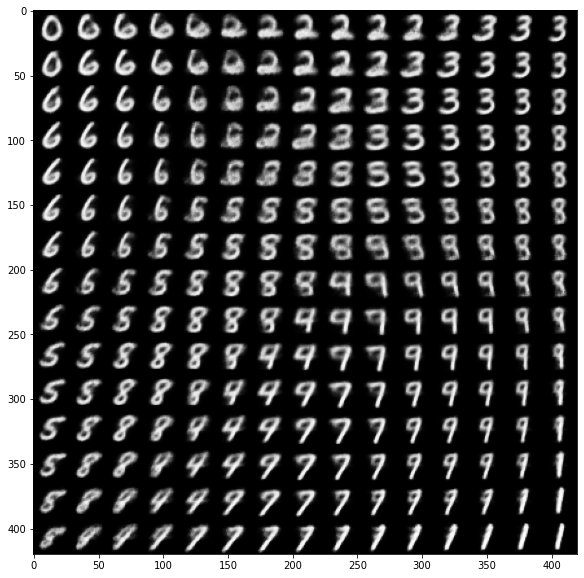

In [9]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줍니다. 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀝니다. 이 공간의 특정 방향은 어떤 의미를 가집니다. 예를 들어 '6으로 가는 방향', '9로 가는 방향' 등입니다.